<a href="https://colab.research.google.com/github/seshiu/pubchem_rdkit/blob/main/PubChem_PUG_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
!pip install altair_viewer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [187]:
!pip install pubchempy
!pip install rdkit
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 4.0 MB/s eta 0:00:00


In [122]:
import requests
import bs4
from bs4 import BeautifulSoup
import re
from statistics import mode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import altair as alt
alt.renderers.enable('altair_viewer')

RendererRegistry.enable('altair_viewer')

In [86]:
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# Working with PUG-REST

Let's try to get all data on aspirin



In [62]:
data = requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/aspirin")
data

<Response [400]>

Hmmm... A 400 response code means error. It looks like we have to specify the output file type. Otherwise, requests won't work.

In [63]:
data = requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/aspirin/xml")
data

<Response [200]>

Ok. Let's parse this information using Beautiful Soup.

In [64]:
html = BeautifulSoup(data.content, "xml")

Let's find out what kind of information we can get.

In [65]:
html.find_all("PC-Urn_label")

[<PC-Urn_label>Compound</PC-Urn_label>,
 <PC-Urn_label>Compound Complexity</PC-Urn_label>,
 <PC-Urn_label>Count</PC-Urn_label>,
 <PC-Urn_label>Count</PC-Urn_label>,
 <PC-Urn_label>Count</PC-Urn_label>,
 <PC-Urn_label>Fingerprint</PC-Urn_label>,
 <PC-Urn_label>IUPAC Name</PC-Urn_label>,
 <PC-Urn_label>IUPAC Name</PC-Urn_label>,
 <PC-Urn_label>IUPAC Name</PC-Urn_label>,
 <PC-Urn_label>IUPAC Name</PC-Urn_label>,
 <PC-Urn_label>IUPAC Name</PC-Urn_label>,
 <PC-Urn_label>IUPAC Name</PC-Urn_label>,
 <PC-Urn_label>InChI</PC-Urn_label>,
 <PC-Urn_label>InChIKey</PC-Urn_label>,
 <PC-Urn_label>Log P</PC-Urn_label>,
 <PC-Urn_label>Mass</PC-Urn_label>,
 <PC-Urn_label>Molecular Formula</PC-Urn_label>,
 <PC-Urn_label>Molecular Weight</PC-Urn_label>,
 <PC-Urn_label>SMILES</PC-Urn_label>,
 <PC-Urn_label>SMILES</PC-Urn_label>,
 <PC-Urn_label>Topological</PC-Urn_label>,
 <PC-Urn_label>Weight</PC-Urn_label>]

Let's get the Molecular Weight. First, we locate the tag.

In [66]:
mw_tag = html.find(name="PC-Urn_label", string="Molecular Weight")
mw_tag

<PC-Urn_label>Molecular Weight</PC-Urn_label>

Then, let's take a look at the parent of this tag.

In [67]:
mw_parents = mw_tag.find_parent("PC-InfoData")
mw_parents

<PC-InfoData>
<PC-InfoData_urn>
<PC-Urn>
<PC-Urn_label>Molecular Weight</PC-Urn_label>
<PC-Urn_datatype>
<PC-UrnDataType value="string">1</PC-UrnDataType>
</PC-Urn_datatype>
<PC-Urn_version>2.1</PC-Urn_version>
<PC-Urn_software>PubChem</PC-Urn_software>
<PC-Urn_source>ncbi.nlm.nih.gov</PC-Urn_source>
<PC-Urn_release>2021.05.07</PC-Urn_release>
</PC-Urn>
</PC-InfoData_urn>
<PC-InfoData_value>
<PC-InfoData_value_sval>180.16</PC-InfoData_value_sval>
</PC-InfoData_value>
</PC-InfoData>

The info we want is contained between 'PC-InfoData_value_sval' tag. So let's get to it.

In [68]:
mw = mw_parents.find('PC-InfoData_value_sval').string
mw

'180.16'

There you go. It takes some playing around with. You can always go to the URL, which will render the data on your browser. That's what I did to help navigate this tree.

# Working with PUG-View

Let's do the same for PUG-View and see what we can get from it for aspirin.

In [69]:
data = requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/2244/xml")
data

<Response [200]>

In [70]:
html = BeautifulSoup(data.content, "xml")

To get an idea of what information is available, we can look up TOCHeadings with html.find_all('TOCHeading'). I'm not gonna run the code here, because it's a really long list. Let's say we want to look up melting points.

In [71]:
mp_tag = html.find(name='TOCHeading', string='Melting Point')
mp_tag

<TOCHeading>Melting Point</TOCHeading>

If you look at the xml structure, you'll see that this TOCHeading has siblings with tags 'Information'. The information we want is the childrean of these 'Information' tag under the tag 'String.' So, to find the first value, we can do this:

In [72]:
mp_tag.find_next_sibling('Information').find(name='String').string

'275 °F (NTP, 1992)'

As you can see, these numbers come with not just the units, but annotations on where the data comes from. Not only that, there are multiple values for melting point, since it's experimentally measured. This was quite a long way to find the melting point. An eaiser way is to include what we want in the URL.

In [73]:
data = requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/2244/xml?heading=Melting+Point")
data

<Response [200]>

In [74]:
html = BeautifulSoup(data.content, "xml")

In [75]:
html.find_all('String')

[<String>275 °F (NTP, 1992)</String>,
 <String>138-140</String>,
 <String>135 °C (rapid heating)</String>,
 <String>135 °C</String>,
 <String>135 °C</String>,
 <String>275 °F</String>,
 <String>275 °F</String>]

実験値は複数あるので、とりあえず最頻値を取得

In [78]:
mode(html.find_all('String')).text

'135 °C'

# 

#CIDのリストから類似の化合物のCIDリストを出す

In [144]:
CID_list0 = [517637, 12827211, 7641, 261668, 5541, 101560]

In [146]:
def get_similar(CID_list, listkey_count=15):

    similar_CID_list = []
    
    for CID in CID_list:
        matches = pcp.get_compounds(CID, 'cid')
        if matches:
            best_match = matches[0]
            similar_compounds = pcp.get_compounds(best_match.isomeric_smiles, 'smiles', searchtype='similarity',listkey_count=listkey_count)

            for c in similar_compounds:
                #print(c.cid)
                similar_CID_list.append(c.cid)

    return similar_CID_list

In [150]:
CID_similar_list = get_similar(CID_list0)

In [152]:
temp = CID_list0 + CID_similar_list

CID_list = sorted(set(temp),key=temp.index)

# CIDのリストがあったときに、Computed PropertiesとExperimental Propertiesを取得

CIDリストからComputer Properties

In [153]:
def cid_to_comp_properties(CID_list,properties_list, listkey_count=10):

    df_properties_all = pd.DataFrame(columns=properties_list)

    for CID in CID_list:

      df_properties = pcp.get_properties(properties_list, CID, 'cid', as_dataframe=True)

      df_properties_all = pd.concat([df_properties_all,df_properties])

    return df_properties_all



In [154]:
df_comp_properties = cid_to_comp_properties(CID_list, ['MolecularFormula','IUPACName','CanonicalSMILES','MolecularWeight', 'XLogP', 'TPSA','Complexity', 'Charge', 'HBondDonorCount', 'HBondAcceptorCount'])
df_comp_properties

,MolecularFormula,IUPACName,CanonicalSMILES,MolecularWeight,XLogP,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount
517637,C17H16O4,2-benzoyloxypropyl benzoate,CC(COC(=O)C1=CC=CC=C1)OC(=O)C2=CC=CC=C2,284.31,3.8,52.6,341,0,0,4
12827211,C21H44O8,2-[2-[2-[2-[2-[2-(2-hydroxypropoxy)propoxy]pro...,CC(CO)OCC(C)OCC(C)OCC(C)OCC(C)OCC(C)OCC(C)O,424.6,0.8,95.8,371,0,2,8
7641,C22H42O4,bis(2-ethylhexyl) hexanedioate,CCCCC(CC)COC(=O)CCCCC(=O)OCC(CC)CCCC,370.6,6.8,52.6,320,0,0,4
261668,C20H22O4,6-benzoyloxyhexyl benzoate,C1=CC=C(C=C1)C(=O)OCCCCCCOC(=O)C2=CC=CC=C2,326.4,6.2,52.6,332,0,0,4
5541,C9H14O6,"2,3-diacetyloxypropyl acetate",CC(=O)OCC(COC(=O)C)OC(=O)C,218.20,0.2,78.9,229,0,0,6
...,...,...,...,...,...,...,...,...,...,...
21896169,C9H18O4,2-(2-methoxypropoxy)propyl acetate,CC(COC(C)COC(=O)C)OC,190.24,0.7,44.8,147,0,0,4
11332757,C8H14O4,"[(2S,3S)-3-acetyloxybutan-2-yl] acetate",CC(C(C)OC(=O)C)OC(=O)C,174.19,0.9,52.6,156,0,0,4
9920499,C8H14O4,2-acetyloxybutyl acetate,CCC(COC(=O)C)OC(=O)C,174.19,1.0,52.6,164,0,0,4
7000074,C8H14O4,[(3R)-3-acetyloxybutyl] acetate,CC(CCOC(=O)C)OC(=O)C,174.19,0.8,52.6,164,0,0,4


CIDリストからExperimental Properties

In [155]:
def cid_to_exp_properties(CID_list, property_name_list, property_heading_list):

  df_properties = pd.DataFrame(index = CID_list, columns = property_name_list)

  for i in range(len(property_name_list)):

    property_name = property_name_list[i]
    property_heading = property_heading_list[i]

    print(property_heading)

    for CID in CID_list:
      data = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{CID}/xml?heading={property_heading}")
      html = BeautifulSoup(data.content, "xml")
      if len(html.find_all('String')) > 0:
        print(mode(html.find_all('String')).text)
        df_properties.loc[CID,property_name] = mode(html.find_all('String')).text
      else:
        df_properties.loc[CID,property_name] = np.nan

  return df_properties


In [156]:
df_exp_properties = cid_to_exp_properties(CID_list, ['MP','RI'], ['Melting+Point','Refractive+Index'])
df_exp_properties

Melting+Point
-3 °C
-67.8 °C
-78 °C
21 °C
-22 °C
-28 °C
-34 °C
38.5 °C
-49 °F (USCG, 1999)
-77.8 °C
-48 °C
-70 °C
-78 °C
10 °F (NTP, 1992)
-48 °C
-35 °C
-31 °C
Refractive+Index
1.542-1.547
Index of refraction: 1.4474 @ 20 °C/D
[n]D/25 between 1,429 and 1,431
Index of refraction: 1.5680 at 20 °C/D
1.490-1.500
INDEX OF REFRACTION: 1.4940 @ 25 °C/D
1.514-1.521
1.492-1.497
Refractive index = 1.5424
1.491-1.497
1.502-1.508
1.503-1.514
1.514-1.521
1.505-1.526
INDEX OF REFRACTION: 1.4449 @ 20 °C/D
Index of refraction: 1.451 @ 25 °C/D
Index of refraction: 1.446 @ 25 °C/D
Index of refraction: 1.5164 at 20 °C
Index of refraction = 1.4867 at 20 °C/D
Index of refraction: 1.535-1.540 at 25 °C/D
INDEX OF REFRACTION: 1.4173 AT 20 °C/D
1.428-1.435
1.415-1.421


,MP,RI
517637,-3 °C,1.542-1.547
12827211,NaN,NaN
7641,-67.8 °C,Index of refraction: 1.4474 @ 20 °C/D
261668,NaN,NaN
5541,-78 °C,"[n]D/25 between 1,429 and 1,431"
...,...,...
21896169,NaN,NaN
11332757,NaN,NaN
9920499,NaN,NaN
7000074,NaN,NaN


In [157]:
df_properties_pubchem = pd.concat([df_comp_properties,df_exp_properties],axis=1)

# rdkit記述子計算

In [158]:
def cal_desc_from_smiles(df, smiles_column):

  smiles_series = df[smiles_column]

  # 計算する記述子名の取得
  descriptor_names = []
  for descriptor_information in Descriptors.descList:
      descriptor_names.append(descriptor_information[0])

  # 記述子の計算
  descriptor_calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
  descriptors = []  # ここに計算された記述子の値を追加
  #print('分子の数 :', len(smiles))
  for index, smiles_i in enumerate(smiles_series):
      #print(index + 1, '/', len(smiles))
      molecule = Chem.MolFromSmiles(smiles_i)
      descriptors.append(descriptor_calculator.CalcDescriptors(molecule))
  descriptors = pd.DataFrame(descriptors, index=df.index, columns=descriptor_names)

  return descriptors

In [159]:
df_rdkit_desc = cal_desc_from_smiles(df_properties_pubchem, 'CanonicalSMILES')
df_rdkit_desc

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
517637,11.807049,11.807049,0.020140,-0.508918,0.791677,284.311,268.183,284.104859,108,0,...,0,0,0,0,0,0,0,0,0,0
12827211,9.208004,9.208004,0.003546,-0.473747,0.324029,424.575,380.223,424.303618,176,0,...,0,0,0,0,0,0,0,0,0,0
7641,11.797764,11.797764,0.139881,-0.139881,0.230356,370.574,328.238,370.308310,154,0,...,0,0,0,0,0,0,0,0,1,0
261668,11.709844,11.709844,0.284823,-0.284823,0.510175,326.392,304.216,326.151809,126,0,...,0,0,0,0,0,0,0,0,5,0
5541,10.640326,10.640326,0.122824,-0.754352,0.478698,218.205,204.093,218.079038,86,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21896169,10.440030,10.440030,0.069239,-0.282185,0.585792,190.239,172.095,190.120509,78,0,...,0,0,0,0,0,0,0,0,0,0
11332757,10.481691,10.481691,0.373609,-0.396852,0.596070,174.196,160.084,174.089209,70,0,...,0,0,0,0,0,0,0,0,0,0
9920499,10.495024,10.495024,0.144259,-0.360554,0.593799,174.196,160.084,174.089209,70,0,...,0,0,0,0,0,0,0,0,0,0
7000074,10.421213,10.421213,0.192731,-0.314792,0.593799,174.196,160.084,174.089209,70,0,...,0,0,0,0,0,0,0,0,0,0


In [163]:
df_rdkit_desc['flag'] = 0
df_rdkit_desc.loc[CID_list0,'flag'] = 1
df_rdkit_desc

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,flag
517637,11.807049,11.807049,0.020140,-0.508918,0.791677,284.311,268.183,284.104859,108,0,...,0,0,0,0,0,0,0,0,0,1
12827211,9.208004,9.208004,0.003546,-0.473747,0.324029,424.575,380.223,424.303618,176,0,...,0,0,0,0,0,0,0,0,0,1
7641,11.797764,11.797764,0.139881,-0.139881,0.230356,370.574,328.238,370.308310,154,0,...,0,0,0,0,0,0,0,1,0,1
261668,11.709844,11.709844,0.284823,-0.284823,0.510175,326.392,304.216,326.151809,126,0,...,0,0,0,0,0,0,0,5,0,1
5541,10.640326,10.640326,0.122824,-0.754352,0.478698,218.205,204.093,218.079038,86,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21896169,10.440030,10.440030,0.069239,-0.282185,0.585792,190.239,172.095,190.120509,78,0,...,0,0,0,0,0,0,0,0,0,0
11332757,10.481691,10.481691,0.373609,-0.396852,0.596070,174.196,160.084,174.089209,70,0,...,0,0,0,0,0,0,0,0,0,0
9920499,10.495024,10.495024,0.144259,-0.360554,0.593799,174.196,160.084,174.089209,70,0,...,0,0,0,0,0,0,0,0,0,0
7000074,10.421213,10.421213,0.192731,-0.314792,0.593799,174.196,160.084,174.089209,70,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
df_rdkit_desc.columns[10:30]

Index(['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge',
       'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2',
       'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI',
       'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI',
       'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n'],
      dtype='object')

# PCA


In [164]:
def tsne(data, columns, perplexity=5):
    
    X = data[columns]

    #全て同じ値の記述子は削除
    X = X.loc[:,~(X.nunique()==1)]
   
    autoscaled_X = (X - X.mean(axis=0)) / X.std(axis=0, ddof=1)
    X_tsne = TSNE(perplexity=perplexity, n_components=2, init='pca',
             random_state=10).fit_transform(autoscaled_X)
    
    X_tsne = pd.DataFrame(X_tsne, index=X.index, columns=['pca1','pca2'])


    plt.scatter(X_tsne['pca1'],X_tsne['pca2'], c=data['flag'])
    plt.show()

    #print(X_tsne)

    # var1 = X_tsne.columns[0]
    # var2 = X_tsne.columns[1]
    # size = 10

    #tooltip_list =  sorted(list(set(Z.columns[:10]) - set(var1 + var2)))
    #chart = alt.Chart(X_tsne,height=500).mark_circle(size=200).encode(x='pca1', y='pca2', color = color).configure_axis(labelFontSize=16,titleFontSize=20)
    #chart = alt.Chart(X_tsne).mark_circle().encode(x='pca1', y='pca2')


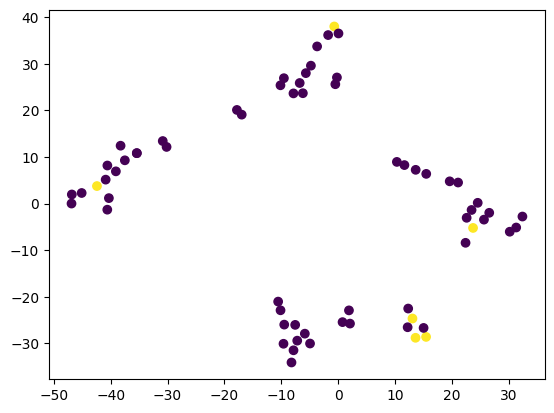

In [165]:
tsne(df_rdkit_desc,df_rdkit_desc.columns[:-1])

In [168]:
df_exp_properties.dropna(how='all')

,MP,RI
517637,-3 °C,1.542-1.547
7641,-67.8 °C,Index of refraction: 1.4474 @ 20 °C/D
5541,-78 °C,"[n]D/25 between 1,429 and 1,431"
2345,21 °C,Index of refraction: 1.5680 at 20 °C/D
23235,NaN,1.490-1.500
8698,-22 °C,INDEX OF REFRACTION: 1.4940 @ 25 °C/D
21265,NaN,1.514-1.521
13654,NaN,1.492-1.497
8437,-28 °C,Refractive index = 1.5424
7193,NaN,1.491-1.497


In [190]:
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(df_comp_properties, "CanonicalSMILES")

In [191]:
selected_CID = list(df_exp_properties.dropna(how='all').index)
selected_rdkit_desc = ['MolLogP','MolMR','FractionCSP3']

df = pd.concat([df_comp_properties.loc[selected_CID,:], df_exp_properties.loc[selected_CID,:],
                df_rdkit_desc.loc[selected_CID,selected_rdkit_desc]],axis=1)

df.insert(0,'cid',df.index)

In [192]:
PandasTools.SaveXlsxFromFrame(df, './sample.xlsx', molCol='ROMol', size=(100,100))

,MolecularFormula,IUPACName,CanonicalSMILES,MolecularWeight,XLogP,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,ROMol,MP,RI,MolLogP,MolMR,FractionCSP3
517637,C17H16O4,2-benzoyloxypropyl benzoate,CC(COC(=O)C1=CC=CC=C1)OC(=O)C2=CC=CC=C2,284.31,3.8,52.6,341,0,0,4,,-3 °C,1.542-1.547,3.0889,78.0440,0.176471
7641,C22H42O4,bis(2-ethylhexyl) hexanedioate,CCCCC(CC)COC(=O)CCCCC(=O)OCC(CC)CCCC,370.6,6.8,52.6,320,0,0,4,,-67.8 °C,Index of refraction: 1.4474 @ 20 °C/D,6.0660,106.9980,0.909091
5541,C9H14O6,"2,3-diacetyloxypropyl acetate",CC(=O)OCC(COC(=O)C)OC(=O)C,218.20,0.2,78.9,229,0,0,6,,-78 °C,"[n]D/25 between 1,429 and 1,431",0.0443,48.8200,0.666667
2345,C14H12O2,benzyl benzoate,C1=CC=C(C=C1)COC(=O)C2=CC=CC=C2,212.24,4.0,26.3,213,0,0,2,,21 °C,Index of refraction: 1.5680 at 20 °C/D,3.0436,62.0035,0.071429
23235,C13H18O2,hexyl benzoate,CCCCCCOC(=O)C1=CC=CC=C1,206.28,4.9,26.3,171,0,0,2,,NaN,1.490-1.500,3.4237,60.8665,0.461538
8698,C11H14O2,butyl benzoate,CCCCOC(=O)C1=CC=CC=C1,178.23,3.8,26.3,148,0,0,2,,-22 °C,INDEX OF REFRACTION: 1.4940 @ 25 °C/D,2.6435,51.6325,0.363636
21265,C12H14O2,3-methylbut-2-enyl benzoate,CC(=CCOC(=O)C1=CC=CC=C1)C,190.24,3.2,26.3,208,0,0,2,,NaN,1.514-1.521,2.8096,56.1555,0.250000
13654,C10H12O2,propan-2-yl benzoate,CC(C)OC(=O)C1=CC=CC=C1,164.20,3.2,26.3,146,0,0,2,,NaN,1.492-1.497,2.2518,46.9935,0.300000
8437,C18H18O5,2-(2-benzoyloxyethoxy)ethyl benzoate,C1=CC=C(C=C1)C(=O)OCCOCCOC(=O)C2=CC=CC=C2,314.3,3.4,61.8,322,0,0,5,,-28 °C,Refractive index = 1.5424,2.7170,84.2680,0.222222
7193,C12H16O2,3-methylbutyl benzoate,CC(C)CCOC(=O)C1=CC=CC=C1,192.25,3.8,26.3,169,0,0,2,,NaN,1.491-1.497,2.8895,56.1795,0.416667

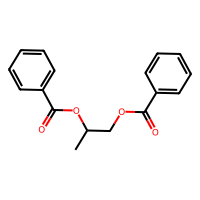
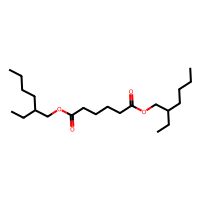
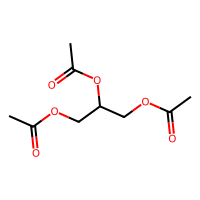
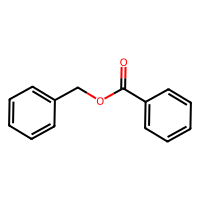
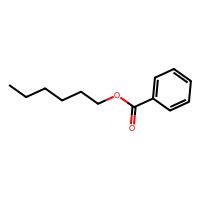
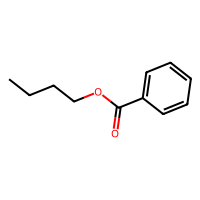
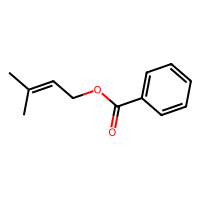
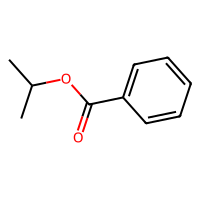
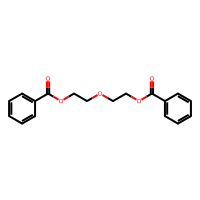
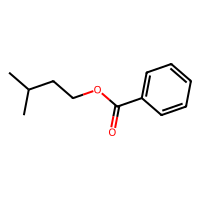
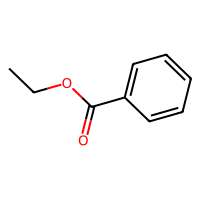
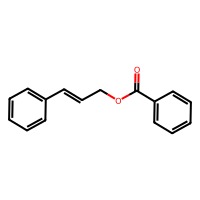
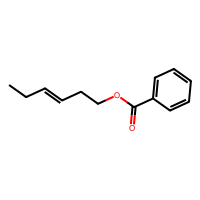
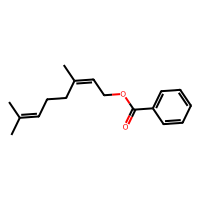
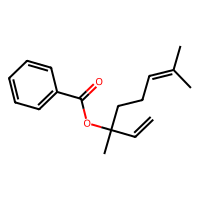
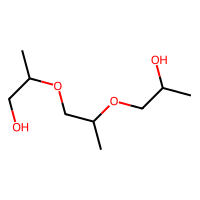
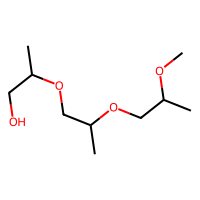
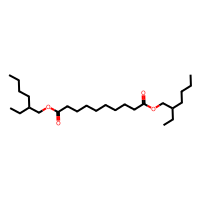
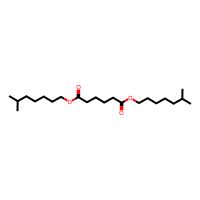
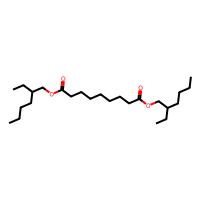
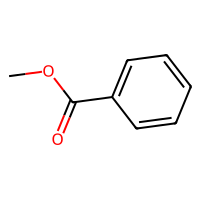
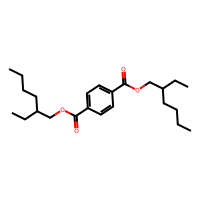
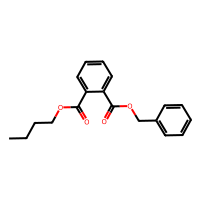
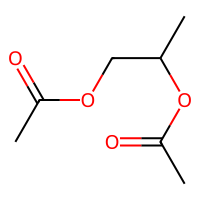
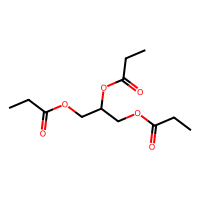
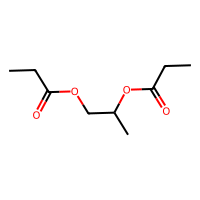

In [184]:
PandasTools.AddMoleculeColumnToFrame(df, "CanonicalSMILES")
df

In [183]:
df.to_csv('desc.csv')

In [175]:
df = df.reindex(columns=['MolecularFormula', 'IUPACName', 'CanonicalSMILES', 'MolecularWeight','ROMol','MP', 'RI',
       'XLogP', 'TPSA', 'Complexity', 'Charge', 'HBondDonorCount',
       'HBondAcceptorCount', 'XLogP', 'MolLogP', 'MolMR', 'FractionCSP3'])

df

,MolecularFormula,IUPACName,CanonicalSMILES,MolecularWeight,ROMol,MP,RI,XLogP,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,XLogP,MolLogP,MolMR,FractionCSP3
517637,C17H16O4,2-benzoyloxypropyl benzoate,CC(COC(=O)C1=CC=CC=C1)OC(=O)C2=CC=CC=C2,284.31,<rdkit.Chem.rdchem.Mol object at 0x7fde43141bd0>,-3 °C,1.542-1.547,3.8,52.6,341,0,0,4,3.8,3.0889,78.0440,0.176471
7641,C22H42O4,bis(2-ethylhexyl) hexanedioate,CCCCC(CC)COC(=O)CCCCC(=O)OCC(CC)CCCC,370.6,<rdkit.Chem.rdchem.Mol object at 0x7fde43142490>,-67.8 °C,Index of refraction: 1.4474 @ 20 °C/D,6.8,52.6,320,0,0,4,6.8,6.0660,106.9980,0.909091
5541,C9H14O6,"2,3-diacetyloxypropyl acetate",CC(=O)OCC(COC(=O)C)OC(=O)C,218.20,<rdkit.Chem.rdchem.Mol object at 0x7fde43142340>,-78 °C,"[n]D/25 between 1,429 and 1,431",0.2,78.9,229,0,0,6,0.2,0.0443,48.8200,0.666667
2345,C14H12O2,benzyl benzoate,C1=CC=C(C=C1)COC(=O)C2=CC=CC=C2,212.24,<rdkit.Chem.rdchem.Mol object at 0x7fde43143220>,21 °C,Index of refraction: 1.5680 at 20 °C/D,4.0,26.3,213,0,0,2,4.0,3.0436,62.0035,0.071429
23235,C13H18O2,hexyl benzoate,CCCCCCOC(=O)C1=CC=CC=C1,206.28,<rdkit.Chem.rdchem.Mol object at 0x7fde43143290>,NaN,1.490-1.500,4.9,26.3,171,0,0,2,4.9,3.4237,60.8665,0.461538
8698,C11H14O2,butyl benzoate,CCCCOC(=O)C1=CC=CC=C1,178.23,<rdkit.Chem.rdchem.Mol object at 0x7fde43143300>,-22 °C,INDEX OF REFRACTION: 1.4940 @ 25 °C/D,3.8,26.3,148,0,0,2,3.8,2.6435,51.6325,0.363636
21265,C12H14O2,3-methylbut-2-enyl benzoate,CC(=CCOC(=O)C1=CC=CC=C1)C,190.24,<rdkit.Chem.rdchem.Mol object at 0x7fde431433e0>,NaN,1.514-1.521,3.2,26.3,208,0,0,2,3.2,2.8096,56.1555,0.250000
13654,C10H12O2,propan-2-yl benzoate,CC(C)OC(=O)C1=CC=CC=C1,164.20,<rdkit.Chem.rdchem.Mol object at 0x7fde431436f0>,NaN,1.492-1.497,3.2,26.3,146,0,0,2,3.2,2.2518,46.9935,0.300000
8437,C18H18O5,2-(2-benzoyloxyethoxy)ethyl benzoate,C1=CC=C(C=C1)C(=O)OCCOCCOC(=O)C2=CC=CC=C2,314.3,<rdkit.Chem.rdchem.Mol object at 0x7fde43143760>,-28 °C,Refractive index = 1.5424,3.4,61.8,322,0,0,5,3.4,2.7170,84.2680,0.222222
7193,C12H16O2,3-methylbutyl benzoate,CC(C)CCOC(=O)C1=CC=CC=C1,192.25,<rdkit.Chem.rdchem.Mol object at 0x7fde431437d0>,NaN,1.491-1.497,3.8,26.3,169,0,0,2,3.8,2.8895,56.1795,0.416667
